<a href="https://colab.research.google.com/github/aayu24/BTP-Phase-II/blob/main/base_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%matplotlib inline

import re
import numpy as np
import statistics as stat
import datetime as dt
import zipfile
# from zipfile import ZipFile
import os
from urllib.request import urlretrieve

#This file reads data from honeypot dataset, process and write the data into bots.txt and humans.txt

num_decimal = 4

In [3]:
#Reading basic info for each user into container
def read_info(filename, container):
    with open(filename, 'r') as f:
        for line in f:
            tokens = re.split("[\t\n]", line)
            #Parse strings to numbers, take out the dates
            parsed_tokens = [tokens[0]] + [int(r) for r in tokens[3:8]]
            #Remove length of screen name from data, which is found to have negative effect on classification accuracy
            parsed_tokens = parsed_tokens[:3] + parsed_tokens[4:]
            #Add # followings / # followers
            parsed_tokens.append(round((parsed_tokens[1]/parsed_tokens[2] if parsed_tokens[2] else 0), num_decimal))
            container.append(parsed_tokens)

In [4]:
#Reading data of a series of # followings for each user
tokens = []
def read_followings(filename, container):
    with open(filename, 'r') as f:
        i = 0
        for line in f:
            tokens = [int(r) for r in re.split("[\D]", line) if r != ""][0:]
            tokens_new = tokens[1:]           
            #Calculate standard deviation of the data
            sd = round(stat.pstdev(tokens), num_decimal)
            #Calcalate standard deviation of differences of the data
            sdd = round(stat.pstdev(list(np.array(tokens[1:]) - np.array(tokens[:-1]))), num_decimal)
            #Calculate lag one autocorrelation of the data
            avg = np.mean(tokens)
            numerator = sum((np.array(tokens[1:]) - avg) * (np.array(tokens[:-1]) - avg))
            denominator = sum((np.array(tokens) - avg) ** 2)
            lac = round(numerator/denominator, num_decimal) if denominator != 0 else 0
            container[i] += [sd, sdd, lac]
            i += 1

In [5]:
#Reading tweets posted by each user
def read_tweets(filename, container):
    curr_userID = ""
    curr_tweet_count = 0
    #Features contained in tweets (current user)
    urls, _at_s, hashtags, weekday_post = [], [], [], []
    #Index for container
    i = 0
    with open(filename, encoding = 'utf-8', mode = 'r') as f:
        while True:
            line = f.readline()
            tokens = [r for r in re.split("[\t\n]", line) if r != ""]
            if not line or tokens[0] != curr_userID and curr_userID:
                #New user found / eof reached
                num_tweets_weekday = [weekday_post.count(i) for i in range(7)]
                ratio_tweets_weekday = [round(x, num_decimal) for x in list(np.array(num_tweets_weekday) / len(weekday_post))]
                curr_user = num_tweets_weekday + ratio_tweets_weekday
                for feature in (urls, _at_s, hashtags):
                    curr_user.append(round(len(feature) / curr_tweet_count, num_decimal))
                    curr_user.append(round(len(set(feature)) / curr_tweet_count, num_decimal))
                while curr_userID != container[i][0]:
                    i += 1
                container[i] += curr_user
                if not line:
                    break
                #Reset current user info containers
                curr_tweet_count = 0
                urls, _at_s, hashtags, weekday_post = [], [], [], []
            #Post date of the tweet
            curr_userID = tokens[0]
            curr_tweet_count += 1
            urls += re.findall('http[\S]+', tokens[2])
            _at_s += re.findall('@[\S]+', tokens[2])
            hashtags += re.findall('#[\S]+', tokens[2])
            post_date = re.split("[-\s]", tokens[3])
            post_date = dt.date(int(post_date[0]), int(post_date[1]), int(post_date[2]))
            weekday_post.append(post_date.weekday())

In [6]:
#Deleting ambiguous users who are in both polluters and legitimate users (44 found)
#The user ids are found in ascending order
def del_amb(bots, humans):
    i, j, count = (0, 0, 0)
    while i < len(bots) and j < len(humans):
        if bots[i][0] == humans[j][0]:
            bots.pop(i)
            humans.pop(j)
            count += 1
        elif int(bots[i][0]) < int(humans[j][0]):
            i += 1
        else:
            j += 1
    return count

#Add 0's for missing values (some users have no tweets recorded)
def add0(container):
    length = 29
    for i in range(len(container)):
        container[i] += [0]*(length - len(container[i]))

In [7]:
#Write data into text files
def write_user(filename, container):
    with open(filename, 'w') as f:
        for inst in container:
            f.write("\t".join([str(x) for x in inst]))
            f.write("\n")

In [8]:
# #Download the dataset
# if not os.path.exists('social_honeypot_icwsm_2011'):
#     if not os.path.exists('social_honeypot_icwsm_2011.zip'):
#         print("downloading data")
#         urlretrieve('http://infolab.tamu.edu/data/social_honeypot_icwsm_2011.zip', 'social_honeypot_icwsm_2011.zip')
#     zip = zipfile.ZipFile('social_honeypot_icwsm_2011.zip')
#     zip.extractall(path = 'social_honeypot_icwsm_2011')
#     zip.close()
#     print("data ready")

In [9]:
#Read, process, and write data into text files
#It takes a few minutes to run, and should run for only once
bots, humans = [], []
read_info('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/content_polluters.txt', bots)
print("data read from social_honeypot_icwsm_2011\content_polluters.txt")
read_info('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/legitimate_users.txt', humans)
print("data read from social_honeypot_icwsm_2011\legitimate_users.txt")

read_followings('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/content_polluters_followings.txt', bots)
print("data read from social_honeypot_icwsm_2011\content_polluters_followings.txt")
read_followings('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/legitimate_users_followings.txt', humans)
print("data read from social_honeypot_icwsm_2011\legitimate_users_followings.txt")

read_tweets('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/content_polluters_tweets.txt', bots)
print("data read from social_honeypot_icwsm_2011\content_polluters_tweets.txt")
read_tweets('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/legitimate_users_tweets.txt', humans)
print("data read from social_honeypot_icwsm_2011\legitimate_users_tweets.txt")

count = del_amb(bots, humans)
print("%d mislabeled users deleted!" % count)
add0(bots)
add0(humans)
print("added 0's for missing values")
    
write_user('bots.txt', bots)
print("data written to bots.txt")
write_user('humans.txt', humans)
print("data written to humans.txt")

data read from social_honeypot_icwsm_2011\content_polluters.txt
data read from social_honeypot_icwsm_2011\legitimate_users.txt
data read from social_honeypot_icwsm_2011\content_polluters_followings.txt
data read from social_honeypot_icwsm_2011\legitimate_users_followings.txt
data read from social_honeypot_icwsm_2011\content_polluters_tweets.txt
data read from social_honeypot_icwsm_2011\legitimate_users_tweets.txt
44 mislabeled users deleted!
added 0's for missing values
data written to bots.txt
data written to humans.txt


In [10]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
#This file reads data from polluters.txt and legitimate_users.txt and do analysis on the data

In [11]:
#Read data from polluters.txt and legitimate_users.txt
polluters = []
reader_1 = open("bots.txt", 'r')
for line in reader_1:
    tokens = [float(r) for r in re.split("[\t\n]", line) if r != ""]
    polluters.append(tokens)
reader_1.close()
print("data read from polluters.txt")
    
legitimate_users = []
reader_2 = open("humans.txt", 'r')
for line in reader_2:
    tokens = [float(r) for r in re.split("[\t\n]", line) if r != ""]
    legitimate_users.append(tokens)
reader_2.close()
print("data read from legitimate_users.txt")


#Combine 2 datasets for classification, dataset_Y is the target list
dataset_X = [r[1:] for r in polluters + legitimate_users]
nodes = [r[0] for r in polluters + legitimate_users]
dataset_Y = [0] * len(polluters) + [1] * len(legitimate_users)

data read from polluters.txt
data read from legitimate_users.txt


In [ ]:
# print(dataset_X.shape)

In [ ]:
# #Plot graph of #followers / #followings to see the data distribution patterns
# humans_patch = mpatches.Patch(color='green', label='Humans')
# bots_patch = mpatches.Patch(color='blue', label='Bots')
# plt.figure(figsize=(10, 8))
# plt.plot([x[0] for x in dataset_X][len(polluters):], [x[1] for x in dataset_X][len(polluters):], "go")
# plt.plot([x[0] for x in dataset_X][:len(polluters)], [x[1] for x in dataset_X][:len(polluters)], "bo")
# plt.legend(handles=[bots_patch, humans_patch])
# plt.axis([-10, 5000, -10, 40000])
# plt.ylabel("Number of followers")
# plt.xlabel("Number of followings")
# plt.title("# followers vs. # followings graph (Bots overlapping)")
# plt.show()

# plt.figure(figsize=(10, 8))
# plt.plot([x[0] for x in dataset_X][:len(polluters)], [x[1] for x in dataset_X][:len(polluters)], "bo")
# plt.plot([x[0] for x in dataset_X][len(polluters):], [x[1] for x in dataset_X][len(polluters):], "go")
# plt.legend(handles=[bots_patch, humans_patch])
# plt.axis([-10, 5000, -10, 40000])
# plt.ylabel("Number of followers")
# plt.xlabel("Number of followings")
# plt.title("# followers vs. # followings graph (Humans overlapping)")
# plt.show()

In [12]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#This file reads data from polluters.txt and legitimate_users.txt and classify the records

In [ ]:
#Separate dataset_X into bins by # followings and # followers and try classification
#Drop some outliers based on the # followers vs. #followings graph
# data_x = []
# data_y = []
# outliers_x = []
# outliers_y = []
# i = 0
# while i < len(dataset_X):
#     if dataset_X[i][0] < 500:
#         if dataset_X[i][1] > 1500:
#             data_x.append(dataset_X[i] + [1, 0, 0])
#             data_y.append(dataset_Y[i])
#         else:
#             data_x.append(dataset_X[i] + [0, 1, 0])
#             data_y.append(dataset_Y[i])
#     elif dataset_X[i][1] < dataset_X[i][0]*0.9+10000:
#         #The #followers/#followings ratio is below the generalized line
#         if dataset_X[i][0] < 2005:
#             data_x.append(dataset_X[i] + [0, 1, 0])
#             data_y.append(dataset_Y[i])
#         else:
#             data_x.append(dataset_X[i] + [0, 0, 1])
#             data_y.append(dataset_Y[i])
#     else:
#         outliers_x.append(dataset_X[i])
#         outliers_y.append(dataset_Y[i])
#     i += 1
# dataset_X = data_x
# dataset_Y = data_y
# print("%d outliers are dropped" % len(outliers_x))

57 outliers are dropped


In [13]:
#Scale each feature of the data with its maximum value
#This is found to give a better result than no scale or scale with both maximum and standard deviation
data_x = dataset_X
data_y = dataset_Y
max_values = np.matrix(data_x).mean(0).tolist()[0][:-1] + [1]
data_x = [[x/y for x, y in list(zip(z, max_values))] for z in data_x]
print("data scaled")
print("%d instances, where %g are bots" % (len(data_x), data_y.count(0)/len(data_y)))

data scaled
41411 instances, where 0.535582 are bots


In [14]:
#Need KFold iterator since method "cross_val_score" doesn't provide shuffling function
kFold = KFold(n_splits = 10, shuffle = True)

#Build the classifier and do classification based on: all numeric features & each numeric feature
lr = LogisticRegression()
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 50)

In [ ]:
#Do classification with Random Forest classifier
#This takes a minute to run

#First use cross_val_score to get a total accuracy
score = np.mean(cross_val_score(rf, X_graph_2, Y_graph_2, cv = kFold,scoring='f1'))
print("\naccuracy:\ntotal:\t%g%%" % round(score*100, 2))

#Then do cross validation manually to get the f1 score and confusion matrix
#Also count misclassified bots and humans respectively, and calculate the accuracies respectively
e_h, e_b = 0, 0
predictions, y_tests = [], []

for train_index, test_index in kFold.split(X_graph_2):
    X_graph_2, Y_graph_2 = np.array(X_graph_2), np.array(Y_graph_2)
    X_train, X_test = list(X_graph_2[train_index]), list(X_graph_2[test_index])
    y_train, y_test = list(Y_graph_2[train_index]), list(Y_graph_2[test_index])
    rf.fit(X_train, y_train)
    prediction = list(rf.predict(X_test))
    predictions += prediction
    y_tests += y_test
    i = 0
    while i < len(y_test):
        if prediction[i] != y_test[i]:
            if y_test[i] == 0:
                e_b += 1
            else:
                e_h += 1
        i += 1
f1_bots = f1_score(y_tests, predictions, pos_label = 0)
f1_humans = f1_score(y_tests, predictions, pos_label = 1)
conf_matrix = np.matrix(list(confusion_matrix(y_tests, predictions)))

print("humans:\t%g%%" % round((1 - e_h/y_tests.count(1))*100, 2))
print("bots:\t%g%%" % round((1 - e_b/y_tests.count(0))*100, 2))
print("\nf1 scores:\nhumans:\t%g%%\nbots:\t%g%%" % (round(f1_humans*100, 2), round(f1_bots*100, 2)))
print("\nconfusion matrix:\n", conf_matrix, "\n")

#FYI, the labels for confusion matrix are:
#         classified as
#         bots     humans
# bots
# humans

NameError: ignored

In [ ]:
!pip install tweepy 

In [ ]:
import tweepy 
import time

In [ ]:
consumerKey = "Cb7u11e49o3SYLQ2LpOuOwvYx"
consumerSecret = "SZ4ZbMHpYLK9qKCPHsbpSF3m1QA6wNdD99xyvlfHBT3I5KLCD9"
accessToken = "1292925954436632576-3hxmOSifgPflLFmWTpJHQKSYxaOUwn"
accessTokenSecret = "rnR2fS2pMrEYgsxYmNmICGi69UIpVrpHg10khPfB8MaAz"

In [ ]:
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)

In [ ]:
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

In [ ]:
def get_followers(id):
    print('Getting Follower list of ',id)
    followers = []
    # followers_screenNames = []
    try:
      # users = tweepy.Cursor(api.followers, id=id, wait_on_rate_limit=True,count=200)
      # for user in users.items():
      #     try:
      #         followers.append(user)
      #         # followers_screenNames.append(user.screen_name)
      #     except tweepy.TweepError as e:
      #         print("Going to sleep:", e)
      #         time.sleep(60)
      # followers = api.followers_ids(id)
      c = tweepy.Cursor(api.followers_ids, id = id)
      for page in c.pages():
        for item in page:
          followers.append(item)
      return followers
    except tweepy.TweepError:
      return followers

In [ ]:
def get_followings(id):
    print('Getting Following list of ',id)
    followings = []
    # followers_screenNames = []
    try:
      # users = tweepy.Cursor(api.followers, id=id, wait_on_rate_limit=True,count=200)
      # for user in users.items():
      #     try:
      #         followers.append(user)
      #         # followers_screenNames.append(user.screen_name)
      #     except tweepy.TweepError as e:
      #         print("Going to sleep:", e)
      #         time.sleep(60)
      c = tweepy.Cursor(api.friends_ids, id=id)
      for page in c.pages():
        for item in page:
          followings.append(item)
      return followings
    except tweepy.TweepError:
      return followings

In [ ]:
node_dict_1 = {}
node_dict_2 = {}
for n in legitimate_users:
  node_dict_1[n[0]]=1
for b in bots:
  node_dict_2[b[0]]=0

In [ ]:
import random
random.seed(0)
bot_nodes = [r[0] for r in polluters]
random.shuffle(bot_nodes)

In [ ]:
sample = get_followers(6301)
print(len(sample))

Getting Follower list of  6301
22273


In [52]:
hashed={}
for node in nodes:
  hashed[node]=1

In [ ]:
print(sample[0] in hash)

False


In [ ]:
sample_ids_in_data = []
for id in sample:
  if id in hash:
    sample_ids_in_data.append(id)

In [ ]:
len(sample_ids_in_data)

81

In [ ]:
cnt=0
for id in sample_ids_in_data:
  if id in bot_nodes:
    cnt=cnt+1

In [ ]:
follower_edges=[]
following_edges=[]
for node in bot_nodes[60:120]:
  followers = get_followers(int(node))
  followings = get_followings(int(node))
  for follower in followers:
    if follower in hash:
      follower_edges.append((node,follower))
  for following in followings:
    if following in hash:
      following_edges.append((node,following))

Getting Follower list of  139638914
Getting Following list of  139638914
Getting Follower list of  26563593
Getting Following list of  26563593
Getting Follower list of  16076678


Rate limit reached. Sleeping for: 865


Getting Following list of  16076678
Getting Follower list of  111485414
Getting Following list of  111485414
Getting Follower list of  60638062
Getting Following list of  60638062
Getting Follower list of  84208989
Getting Following list of  84208989


Rate limit reached. Sleeping for: 21


Getting Follower list of  111714739
Getting Following list of  111714739
Getting Follower list of  51822370
Getting Following list of  51822370
Getting Follower list of  91729026
Getting Following list of  91729026


Rate limit reached. Sleeping for: 868


Getting Follower list of  135820831


KeyboardInterrupt: ignored

In [ ]:
shuffled_nodes = nodes
random.shuffle(shuffled_nodes)

In [ ]:
# bot_nodes = []
# legit_nodes = []
# for node in shuffled_nodes[:200]:
#   if node_dict[int(node)]==0:
#     bot_nodes.append(int(node))
#   elif node_dict[int(node)]==1:
#     legit_nodes.append(int(node))
#   else:
#     continue

In [ ]:
get_followers(6310)

Getting Follower list of  6310


[]

In [ ]:
final_edges=[]
for node in nodes[:1000]:
  followers = get_followers(int(node))
  for follower in followers:
    if follower in hash:
      final_edges.append((node,follower))

Getting Follower list of  6301
Getting Follower list of  10836
Getting Follower list of  10997
Getting Follower list of  633293
Getting Follower list of  717883
Getting Follower list of  763068
Getting Follower list of  783705
Getting Follower list of  788352
Getting Follower list of  810011
Getting Follower list of  815299
Getting Follower list of  817045
Getting Follower list of  964981
Getting Follower list of  1091571
Getting Follower list of  1303381


Rate limit reached. Sleeping for: 773


Getting Follower list of  1322691
Getting Follower list of  1467621
Getting Follower list of  1599001
Getting Follower list of  1907361
Getting Follower list of  2077351
Getting Follower list of  2157321
Getting Follower list of  2219081
Getting Follower list of  2243161
Getting Follower list of  2269491
Getting Follower list of  2695911
Getting Follower list of  2884771
Getting Follower list of  3060631
Getting Follower list of  3076591
Getting Follower list of  3136731
Getting Follower list of  3291901


Rate limit reached. Sleeping for: 887


Getting Follower list of  3881391
Getting Follower list of  3908631
Getting Follower list of  4000261
Getting Follower list of  4046051
Getting Follower list of  4319321
Getting Follower list of  4567451
Getting Follower list of  5169871
Getting Follower list of  5414782
Getting Follower list of  5439702
Getting Follower list of  5448632
Getting Follower list of  5609382
Getting Follower list of  5693062
Getting Follower list of  5732162
Getting Follower list of  5751742
Getting Follower list of  5775622


Rate limit reached. Sleeping for: 892


Getting Follower list of  5884032
Getting Follower list of  5925162
Getting Follower list of  5925682
Getting Follower list of  5971902
Getting Follower list of  6002602
Getting Follower list of  6087712
Getting Follower list of  6154322
Getting Follower list of  6228472
Getting Follower list of  6267832
Getting Follower list of  6332272
Getting Follower list of  6333392
Getting Follower list of  6356472
Getting Follower list of  6774442
Getting Follower list of  6859412
Getting Follower list of  6861662
Getting Follower list of  6871812


Rate limit reached. Sleeping for: 896


Getting Follower list of  6901952
Getting Follower list of  6902602
Getting Follower list of  6982452
Getting Follower list of  7024522
Getting Follower list of  7082702
Getting Follower list of  7087112
Getting Follower list of  7103212
Getting Follower list of  7159492
Getting Follower list of  7251502
Getting Follower list of  7283562
Getting Follower list of  7350652
Getting Follower list of  7361162
Getting Follower list of  7400262
Getting Follower list of  7540482
Getting Follower list of  7545332
Getting Follower list of  7601182


Rate limit reached. Sleeping for: 896


Getting Follower list of  7721172
Getting Follower list of  7831092
Getting Follower list of  7891352
Getting Follower list of  7891802
Getting Follower list of  7934702
Getting Follower list of  7946942
Getting Follower list of  7950312
Getting Follower list of  7957772
Getting Follower list of  7967132
Getting Follower list of  7977182
Getting Follower list of  8014432
Getting Follower list of  8014472
Getting Follower list of  8066562
Getting Follower list of  8180582
Getting Follower list of  8205942
Getting Follower list of  8208482


Rate limit reached. Sleeping for: 895


Getting Follower list of  8245052
Getting Follower list of  8293982
Getting Follower list of  8377772
Getting Follower list of  8431212
Getting Follower list of  8440552
Getting Follower list of  8571252
Getting Follower list of  8614702
Getting Follower list of  8729092
Getting Follower list of  8773632
Getting Follower list of  8833312
Getting Follower list of  8865022
Getting Follower list of  8894582
Getting Follower list of  9028902
Getting Follower list of  9045162
Getting Follower list of  9082652


Rate limit reached. Sleeping for: 895


Getting Follower list of  9126092
Getting Follower list of  9222382
Getting Follower list of  9237672
Getting Follower list of  9256422
Getting Follower list of  9283632
Getting Follower list of  9285422
Getting Follower list of  9337172
Getting Follower list of  9337212
Getting Follower list of  9376622
Getting Follower list of  9502542
Getting Follower list of  9520902
Getting Follower list of  9545532
Getting Follower list of  9571962
Getting Follower list of  9578362
Getting Follower list of  9596392
Getting Follower list of  9633112


Rate limit reached. Sleeping for: 895


Getting Follower list of  9666402
Getting Follower list of  9751642
Getting Follower list of  9767082
Getting Follower list of  9783422
Getting Follower list of  9814222
Getting Follower list of  9819072
Getting Follower list of  9836582
Getting Follower list of  9922242
Getting Follower list of  9934462
Getting Follower list of  10046572
Getting Follower list of  10105822
Getting Follower list of  10193122
Getting Follower list of  10197782
Getting Follower list of  10278192
Getting Follower list of  10336042
Getting Follower list of  10433782


Rate limit reached. Sleeping for: 895


Getting Follower list of  10492902
Getting Follower list of  10500072
Getting Follower list of  10667662
Getting Follower list of  10697222
Getting Follower list of  10736862
Getting Follower list of  10746692
Getting Follower list of  10778972
Getting Follower list of  10779802
Getting Follower list of  10793242
Getting Follower list of  10845372
Getting Follower list of  10870512
Getting Follower list of  10987282
Getting Follower list of  11009092
Getting Follower list of  11015372
Getting Follower list of  11041822
Getting Follower list of  11073902


Rate limit reached. Sleeping for: 896


Getting Follower list of  11228722
Getting Follower list of  11294262
Getting Follower list of  11305742
Getting Follower list of  11341332
Getting Follower list of  11403052
Getting Follower list of  11403462
Getting Follower list of  11410012
Getting Follower list of  11410412
Getting Follower list of  11422132
Getting Follower list of  11488822
Getting Follower list of  11525652
Getting Follower list of  11547732
Getting Follower list of  11605832
Getting Follower list of  11637322
Getting Follower list of  11662532
Getting Follower list of  11721472


Rate limit reached. Sleeping for: 895


Getting Follower list of  11749762
Getting Follower list of  11756702
Getting Follower list of  11778632
Getting Follower list of  11786162
Getting Follower list of  11862162
Getting Follower list of  11879272
Getting Follower list of  11908322
Getting Follower list of  11920772
Getting Follower list of  11929882
Getting Follower list of  11996952
Getting Follower list of  12022042
Getting Follower list of  12031352
Getting Follower list of  12037882
Getting Follower list of  12085042
Getting Follower list of  12198062
Getting Follower list of  12317562


Rate limit reached. Sleeping for: 896


Getting Follower list of  12357122
Getting Follower list of  12441712
Getting Follower list of  12447572
Getting Follower list of  12449542
Getting Follower list of  12465192
Getting Follower list of  12470242
Getting Follower list of  12511062
Getting Follower list of  12516722
Getting Follower list of  12524522
Getting Follower list of  12552662
Getting Follower list of  12570402
Getting Follower list of  12604592
Getting Follower list of  12611082
Getting Follower list of  12614402
Getting Follower list of  12691382
Getting Follower list of  12720232


Rate limit reached. Sleeping for: 895


Getting Follower list of  12728672
Getting Follower list of  12738932
Getting Follower list of  12755642
Getting Follower list of  12757982
Getting Follower list of  12767492
Getting Follower list of  12811112
Getting Follower list of  12822322
Getting Follower list of  12891732
Getting Follower list of  12930392
Getting Follower list of  12992802
Getting Follower list of  12993022
Getting Follower list of  13027572
Getting Follower list of  13076522
Getting Follower list of  13117172
Getting Follower list of  13122832
Getting Follower list of  13203082


Rate limit reached. Sleeping for: 895


Getting Follower list of  13225732
Getting Follower list of  13247052
Getting Follower list of  13267042
Getting Follower list of  13372502
Getting Follower list of  13372592
Getting Follower list of  13421862
Getting Follower list of  13430962
Getting Follower list of  13458112
Getting Follower list of  13492762
Getting Follower list of  13545202
Getting Follower list of  13571462
Getting Follower list of  13593132
Getting Follower list of  13596992
Getting Follower list of  13601052
Getting Follower list of  13639262
Getting Follower list of  13642652


Rate limit reached. Sleeping for: 895


Getting Follower list of  13688802
Getting Follower list of  13694202
Getting Follower list of  13728412
Getting Follower list of  13788342
Getting Follower list of  13796572
Getting Follower list of  13808342
Getting Follower list of  13831152
Getting Follower list of  13852942
Getting Follower list of  13893342
Getting Follower list of  13898062
Getting Follower list of  14024532
Getting Follower list of  14025402
Getting Follower list of  14057903
Getting Follower list of  14065888
Getting Follower list of  14079004
Getting Follower list of  14087461


Rate limit reached. Sleeping for: 895


Getting Follower list of  14088485
Getting Follower list of  14095473
Getting Follower list of  14099861
Getting Follower list of  14100363
Getting Follower list of  14106080
Getting Follower list of  14106277
Getting Follower list of  14117843
Getting Follower list of  14118173
Getting Follower list of  14118517
Getting Follower list of  14119845
Getting Follower list of  14121525
Getting Follower list of  14131099
Getting Follower list of  14133288
Getting Follower list of  14134831
Getting Follower list of  14138443
Getting Follower list of  14138657


Rate limit reached. Sleeping for: 895


Getting Follower list of  14146618
Getting Follower list of  14151220
Getting Follower list of  14155663
Getting Follower list of  14158133
Getting Follower list of  14167013
Getting Follower list of  14169174
Getting Follower list of  14170609
Getting Follower list of  14177844
Getting Follower list of  14178758
Getting Follower list of  14185487
Getting Follower list of  14185827
Getting Follower list of  14195582
Getting Follower list of  14196378
Getting Follower list of  14200437
Getting Follower list of  14206085
Getting Follower list of  14212278


Rate limit reached. Sleeping for: 895


Getting Follower list of  14213042
Getting Follower list of  14213969
Getting Follower list of  14216821
Getting Follower list of  14221134
Getting Follower list of  14235401
Getting Follower list of  14236327
Getting Follower list of  14239363
Getting Follower list of  14240899
Getting Follower list of  14248266
Getting Follower list of  14249388
Getting Follower list of  14249798
Getting Follower list of  14251168
Getting Follower list of  14252975
Getting Follower list of  14253343
Getting Follower list of  14255846
Getting Follower list of  14257808


Rate limit reached. Sleeping for: 895


Getting Follower list of  14275501
Getting Follower list of  14278708
Getting Follower list of  14278915
Getting Follower list of  14286401
Getting Follower list of  14306558
Getting Follower list of  14310835
Getting Follower list of  14313986
Getting Follower list of  14317166
Getting Follower list of  14317480
Getting Follower list of  14323467
Getting Follower list of  14335577
Getting Follower list of  14338005
Getting Follower list of  14339170
Getting Follower list of  14348419
Getting Follower list of  14351877
Getting Follower list of  14358053


Rate limit reached. Sleeping for: 895


Getting Follower list of  14364397
Getting Follower list of  14365084
Getting Follower list of  14365379
Getting Follower list of  14367635
Getting Follower list of  14368027
Getting Follower list of  14371266
Getting Follower list of  14372559
Getting Follower list of  14373091
Getting Follower list of  14378272
Getting Follower list of  14379113
Getting Follower list of  14387385
Getting Follower list of  14388366
Getting Follower list of  14391473
Getting Follower list of  14392094
Getting Follower list of  14394428
Getting Follower list of  14401806


Rate limit reached. Sleeping for: 895


Getting Follower list of  14404371
Getting Follower list of  14405120
Getting Follower list of  14405773
Getting Follower list of  14417392
Getting Follower list of  14426942
Getting Follower list of  14429823
Getting Follower list of  14433036
Getting Follower list of  14435478
Getting Follower list of  14439302
Getting Follower list of  14444226
Getting Follower list of  14449469
Getting Follower list of  14449487
Getting Follower list of  14451294
Getting Follower list of  14451520
Getting Follower list of  14453409
Getting Follower list of  14453620


Rate limit reached. Sleeping for: 895


Getting Follower list of  14453833
Getting Follower list of  14457457
Getting Follower list of  14463523
Getting Follower list of  14463537
Getting Follower list of  14464835
Getting Follower list of  14466304
Getting Follower list of  14466733
Getting Follower list of  14468043
Getting Follower list of  14470037
Getting Follower list of  14478399
Getting Follower list of  14485062
Getting Follower list of  14486811
Getting Follower list of  14501811
Getting Follower list of  14505596
Getting Follower list of  14507201
Getting Follower list of  14511995


Rate limit reached. Sleeping for: 895


Getting Follower list of  14515351
Getting Follower list of  14516920
Getting Follower list of  14517930
Getting Follower list of  14518714
Getting Follower list of  14522944
Getting Follower list of  14536664
Getting Follower list of  14536884
Getting Follower list of  14538308
Getting Follower list of  14542251
Getting Follower list of  14546963
Getting Follower list of  14548188
Getting Follower list of  14548883
Getting Follower list of  14562016
Getting Follower list of  14563984
Getting Follower list of  14564148
Getting Follower list of  14565842


Rate limit reached. Sleeping for: 895


Getting Follower list of  14573272
Getting Follower list of  14574552
Getting Follower list of  14588236
Getting Follower list of  14609388
Getting Follower list of  14624975
Getting Follower list of  14627467
Getting Follower list of  14631818
Getting Follower list of  14634648
Getting Follower list of  14635511
Getting Follower list of  14660169
Getting Follower list of  14660807
Getting Follower list of  14664352
Getting Follower list of  14665515
Getting Follower list of  14669269
Getting Follower list of  14675924
Getting Follower list of  14680117


Rate limit reached. Sleeping for: 895


KeyboardInterrupt: ignored

In [ ]:
len(follower_edges), len(following_edges)

(2197, 2341)

In [ ]:
count=0
for edge in follower_edges:
  if edge[0] in hash:
    if edge[1] in hash:
      count=count+1

In [ ]:
count

2197

In [ ]:
count=0
for edge in following_edges:
  if edge[0] in hash:
    if edge[1] in hash:
      count=count+1
count

2341

In [18]:
bot_nodes_dict = {int(r[0]):1 for r in polluters}

In [ ]:
bot_count=0
legit_nodes=[]
bot_nodes=[]
for edge in follower_edges:
  if edge[0] in bot_nodes_dict:
    bot_count=bot_count+1
    bot_nodes.append(edge[0])
    if edge[1] in bot_nodes_dict:
      bot_nodes.append(edge[1])
      bot_count=bot_count+1
    else:
      legit_nodes.append(edge[1])
  else:
    legit_nodes.append(edge[0])

In [ ]:
bot_count

4273

In [ ]:
legit_nodes=list(set(legit_nodes))

In [ ]:
bot_nodes=list(set(bot_nodes))

In [ ]:
len(bot_nodes),len(legit_nodes)

(1663, 92)

In [19]:
legit_nodes_dict = {int(r[0]):1 for r in legitimate_users}

In [ ]:
cnt=0
for node in legit_nodes:
  if node in legit_nodes_dict:
    cnt=cnt+1

In [ ]:
cnt

586

In [ ]:
for node in legit_nodes:
  followers = get_followers(int(node))
  followings = get_followings(int(node))
  for follower in followers:
    if follower in hash:
      follower_edges.append((node,follower))
  for following in followings:
    if following in hash:
      following_edges.append((node,following))

Getting Follower list of  14497300


Rate limit reached. Sleeping for: 526


Getting Following list of  14497300
Getting Follower list of  22135849
Getting Following list of  22135849
Getting Follower list of  83428907
Getting Following list of  83428907
Getting Follower list of  26658350
Getting Following list of  26658350
Getting Follower list of  77762110
Getting Following list of  77762110
Getting Follower list of  19566658
Getting Following list of  19566658
Getting Follower list of  26374737
Getting Following list of  26374737
Getting Follower list of  27884629
Getting Following list of  27884629
Getting Follower list of  8548952
Getting Following list of  8548952
Getting Follower list of  18035802
Getting Following list of  18035802
Getting Follower list of  40851547
Getting Following list of  40851547
Getting Follower list of  19673697
Getting Following list of  19673697
Getting Follower list of  24618090
Getting Following list of  24618090
Getting Follower list of  16956020
Getting Following list of  16956020
Getting Follower list of  67227772
Getting 

Rate limit reached. Sleeping for: 890


Getting Following list of  89982079
Getting Follower list of  76446336
Getting Following list of  76446336
Getting Follower list of  77018247
Getting Following list of  77018247
Getting Follower list of  15066760
Getting Following list of  15066760
Getting Follower list of  15502486
Getting Following list of  15502486
Getting Follower list of  22767263
Getting Following list of  22767263
Getting Follower list of  89209508
Getting Following list of  89209508
Getting Follower list of  14076588
Getting Following list of  14076588
Getting Follower list of  14080704
Getting Following list of  14080704
Getting Follower list of  40286926
Getting Following list of  40286926
Getting Follower list of  78073551
Getting Following list of  78073551
Getting Follower list of  67689179
Getting Following list of  67689179
Getting Follower list of  3366641
Getting Following list of  3366641
Getting Follower list of  20007155
Getting Following list of  20007155
Getting Follower list of  19242232
Getting 

Rate limit reached. Sleeping for: 890


Getting Following list of  90444025
Getting Follower list of  88428288
Getting Following list of  88428288
Getting Follower list of  91909378
Getting Following list of  91909378
Getting Follower list of  58292998
Getting Following list of  58292998
Getting Follower list of  46243590
Getting Following list of  46243590
Getting Follower list of  81580808
Getting Following list of  81580808
Getting Follower list of  50551561
Getting Following list of  50551561
Getting Follower list of  29103884
Getting Following list of  29103884
Getting Follower list of  73507088
Getting Following list of  73507088
Getting Follower list of  42373905
Getting Following list of  42373905
Getting Follower list of  21116178
Getting Following list of  21116178
Getting Follower list of  19062548
Getting Following list of  19062548
Getting Follower list of  70839579
Getting Following list of  70839579
Getting Follower list of  53258013
Getting Following list of  53258013
Getting Follower list of  70501151
Gettin

Rate limit reached. Sleeping for: 890


Getting Following list of  7490342
Getting Follower list of  62253864
Getting Following list of  62253864
Getting Follower list of  26951466
Getting Following list of  26951466
Getting Follower list of  81879851
Getting Following list of  81879851
Getting Follower list of  70714671
Getting Following list of  70714671
Getting Follower list of  56166712
Getting Following list of  56166712
Getting Follower list of  91333442
Getting Following list of  91333442
Getting Follower list of  15783240
Getting Following list of  15783240
Getting Follower list of  72550737
Getting Following list of  72550737
Getting Follower list of  16824146
Getting Following list of  16824146
Getting Follower list of  82724693
Getting Following list of  82724693
Getting Follower list of  71490397
Getting Following list of  71490397
Getting Follower list of  58981222
Getting Following list of  58981222
Getting Follower list of  90991975
Getting Following list of  90991975
Getting Follower list of  15928168
Getting

Rate limit reached. Sleeping for: 889


Getting Following list of  61359976
Getting Follower list of  54456684
Getting Following list of  54456684
Getting Follower list of  71015277
Getting Following list of  71015277
Getting Follower list of  48660845
Getting Following list of  48660845
Getting Follower list of  18244473
Getting Following list of  18244473
Getting Follower list of  24906622
Getting Following list of  24906622
Getting Follower list of  68740996
Getting Following list of  68740996
Getting Follower list of  20678540
Getting Following list of  20678540
Getting Follower list of  92364172
Getting Following list of  92364172
Getting Follower list of  34397068
Getting Following list of  34397068
Getting Follower list of  27094415
Getting Following list of  27094415
Getting Follower list of  81825679
Getting Following list of  81825679
Getting Follower list of  48141717
Getting Following list of  48141717
Getting Follower list of  86877590
Getting Following list of  86877590
Getting Follower list of  15471509
Gettin

Rate limit reached. Sleeping for: 890


Getting Following list of  24626089
Getting Follower list of  84746156
Getting Following list of  84746156
Getting Follower list of  82037168
Getting Following list of  82037168
Getting Follower list of  14905780
Getting Following list of  14905780
Getting Follower list of  14180279
Getting Following list of  14180279
Getting Follower list of  35728314
Getting Following list of  35728314
Getting Follower list of  20691901
Getting Following list of  20691901
Getting Follower list of  70807489
Getting Following list of  70807489
Getting Follower list of  89132486
Getting Following list of  89132486
Getting Follower list of  15039436
Getting Following list of  15039436
Getting Follower list of  19498445
Getting Following list of  19498445
Getting Follower list of  44872143
Getting Following list of  44872143
Getting Follower list of  51224018
Getting Following list of  51224018
Getting Follower list of  50008018
Getting Following list of  50008018
Getting Follower list of  46384092
Gettin

Rate limit reached. Sleeping for: 889


Getting Following list of  16425451
Getting Follower list of  18295287
Getting Following list of  18295287


In [ ]:
for edge in follower_edges:
  if edge[1] in bot_nodes_dict:
    bot_nodes.append(edge[1])
    bot_count=bot_count+1
  else:
    legit_nodes.append(edge[1])

In [ ]:
# hash

In [ ]:
# all_edges = []
# with open('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/content_polluters_followings.txt', 'r') as f:
#         i = 0
#         for line in f:
#             tokens = [int(r) for r in re.split("[\D]", line) if r != ""][0:]
#             for t in tokens[1:]:
#               all_edges.append((tokens[0], t))

# with open('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/legitimate_users_followings.txt', 'r') as f:
#         i = 0
#         for line in f:
#             tokens = [int(r) for r in re.split("[\D]", line) if r != ""][0:]
#             for t in tokens[1:]:
#               all_edges.append((tokens[0], t))

In [ ]:
# print(all_edges[10])

In [ ]:
follower_edges = list(set(follower_edges))

In [ ]:
len(follower_edges)

19101

In [20]:
# legit_nodes_dict={node:1 for node in legit_nodes}

In [ ]:
final_follower_edges=[]
for edge in follower_edges:
  if edge[0] in legit_nodes_dict:
    final_follower_edges.append(edge)
  elif edge[1] in legit_nodes_dict:
    final_follower_edges.append(edge)

In [ ]:
len(final_follower_edges)

17025

In [ ]:
follower_bots=[]
for edge in final_follower_edges:
  if edge[0] in bot_nodes_dict:
    follower_bots.append(edge[0])
  elif edge[1] in bot_nodes_dict:
    follower_bots.append(edge[1])

In [ ]:
follower_bots=list(set(follower_bots))

In [ ]:
len(follower_bots)

5368

In [ ]:
# np.max(nodes)

In [ ]:
hash[6301]

1

In [ ]:
legit_nodes=list(set(legit_nodes))

In [ ]:
bot_nodes=list(set(bot_nodes))

In [ ]:
len(follower_edges),len(following_edges)

(19101, 23614)

In [ ]:
len(legit_nodes)

290

In [ ]:
len(bot_nodes)

5731

In [ ]:
with open('follower_edges.txt', 'w') as f:
    for edge in follower_edges:
        f.write('%s %s\n' % edge)

In [ ]:
len(bot_nodes_dict)

22179

## Reading from File

In [74]:
follower_edges = []
with open('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/follower_edges.txt', 'r') as f:
    for line in f:
        tokens = re.split("[ \n]", line)
        #Parse strings to numbers, take out the dates
        l1 = int(tokens[0])
        l2 = int(tokens[1])
        follower_edges.append((l1, l2))

ValueError: ignored

### Following Edges

In [15]:
following_edges = []
with open('/content/gdrive/MyDrive/BTP/social_honeypot_icwsm_2011/following_edges.txt', 'r') as f:
    for line in f:
        tokens = re.split("[ \n]", line)
        #Parse strings to numbers, take out the dates
        l1 = float(tokens[0])
        l2 = float(tokens[1])
        following_edges.append((l1, l2))

In [ ]:
len([r[0] for r in polluters])

22179

In [22]:
following_edges_2 = [(int(a), int(b)) for a,b in following_edges]

In [23]:
following_bot_count=0
following_legit_nodes=[]
following_bot_nodes=[]
for edge in following_edges_2:
  if int(edge[0]) in bot_nodes_dict:
    following_bot_count=following_bot_count+1
    following_bot_nodes.append(int(edge[0]))
    if int(edge[1]) in bot_nodes_dict:
      following_bot_nodes.append(int(edge[1]))
      following_bot_count=following_bot_count+1
    else:
      following_legit_nodes.append(int(edge[1]))
  else:
    following_legit_nodes.append(int(edge[0]))

In [24]:
len(following_bot_nodes), len(following_legit_nodes)

(4485, 21470)

In [25]:
following_bot_nodes=list(set(following_bot_nodes))

In [26]:
len(following_bot_nodes), len(following_legit_nodes)

(1775, 21470)

In [27]:
following_legit_nodes=list(set(following_legit_nodes))

In [28]:
len(following_bot_nodes), len(following_legit_nodes)

(1775, 199)

In [29]:
final_following_edges=[]
for edge in following_edges:
  if edge[0] in legit_nodes_dict:
    final_following_edges.append(edge)
  elif edge[1] in legit_nodes_dict:
    final_following_edges.append(edge)

In [30]:
len(final_following_edges)

21470

In [31]:
following_bots=[]
for edge in final_following_edges:
  if edge[0] in bot_nodes_dict:
    following_bots.append(edge[0])
  elif edge[1] in bot_nodes_dict:
    following_bots.append(edge[1])

In [32]:
following_bots=list(set(following_bots))

In [ ]:
with open('following_edges.txt', 'w') as f:
    for edge in following_edges:
        f.write('%s %s\n' % edge)

In [ ]:
# new_edges = []
# for edge in all_edges:
#   if edge[0] in hash:
#     if edge[1] in hash:
#       new_edges.append(edge)

In [ ]:
# len(new_edges)

In [75]:
len(nodes), len(dataset_X)

(41411, 41411)

In [76]:
nodes_list=list(set(nodes))
len(nodes_list)

41411

In [34]:
hash_pos={}
i=0
for node in nodes:
  hash_pos[node]=i
  i=i+1

In [ ]:
# dataset_X[0]

In [35]:
X_graph=[]
Y_graph=[]
for node in following_bot_nodes:
  X_graph.append(dataset_X[hash_pos[node]]) 
  Y_graph.append(0)

In [36]:
for node in following_legit_nodes:
  X_graph.append(dataset_X[hash_pos[node]])
  Y_graph.append(1)

In [37]:
len(dataset_X[0]) , len(dataset_Y)

(28, 41411)

In [38]:
len(X_graph[0]), len(Y_graph)

(28, 1974)

In [39]:
len(X_graph)

1974

In [ ]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


# train_idx,val_idx,test_idx = limit_data(dataset_Y)
train_idx,val_idx,test_idx = limit_data(Y_graph_2,3000,1000)
# N = len(nodes)
N=len(Y_graph_2)
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [92]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

# labels_encoded, classes = encode_label(dataset_Y)
labels_encoded, classes = encode_label(Y_graph_2)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
!pip install spektral

In [ ]:
# len(dataset_X)

In [40]:
nodes_in_X=[]
for node in following_bot_nodes:
  nodes_in_X.append(node)
for node in following_legit_nodes:
  nodes_in_X.append(node)

In [41]:
len(nodes_in_X), (len(following_bot_nodes)+len(following_legit_nodes))

(1974, 1974)

In [42]:
len(following_edges)

23614

In [43]:
node_count = {}
for edge in following_edges_2:
  if edge[0] not in node_count:
    node_count[edge[0]]=1
  if edge[1] not in node_count:
    node_count[edge[1]]=1

In [44]:
len(node_count)

7547

In [45]:
key_list = [key for key in node_count.keys()]

In [46]:
len(key_list)

7547

In [47]:
key_list=list(set(key_list))

In [48]:
X_graph_2=[]
Y_graph_2=[]
for key in key_list:
  pos = hash_pos[key]
  X_graph_2.append(dataset_X[pos])
  Y_graph_2.append(dataset_Y[pos])

In [49]:
len(key_list), len(X_graph_2), len(Y_graph_2)

(7547, 7547, 7547)

In [54]:
len(hashed)

41411

In [55]:
cnt=0
for key in key_list:
  if key not in hashed:
    cnt=cnt+1
    # print(key)

In [56]:
cnt=0
for key in key_list:
  if key not in following_bot_nodes:
    cnt=cnt+1
    # print(key)

In [57]:
cnt

5772

In [58]:
bot_nodes_dict[22642225]

1

In [60]:
hashed[22642225]

1

In [61]:
cnt=0
for key in key_list:
  if key not in following_legit_nodes:
    if key not in following_bot_nodes:
      cnt=cnt+1
      # print(key)

In [62]:
cnt

5573

In [63]:
cnt=0
for key in key_list:
  if key not in following_legit_nodes:
    cnt=cnt+1
    # print(key)

In [64]:
cnt

7348

In [ ]:
G1 = nx.Graph()
G1.add_nodes_from(nodes_in_X)
nx.info(G1)

'Name: \nType: Graph\nNumber of nodes: 1974\nNumber of edges: 0\nAverage degree:   0.0000'

In [ ]:
# for edge in following_edges:
#   edge = (int(edge[0]),int(edge[1]))
following_edges_2 = [(int(a), int(b)) for a,b in following_edges]

In [ ]:
following_edges_2

[(81825679, 67941063),
 (16956020, 43871439),
 (97263446, 94321077),
 (73507088, 88124039),
 (81825679, 93833100),
 (24618090, 92930094),
 (91333442, 24461721),
 (68740996, 111422421),
 (91333442, 49015544),
 (70839579, 132095145),
 (58292998, 16275559),
 (71490397, 81265165),
 (44872143, 52753358),
 (16425451, 111276953),
 (26374737, 18651977),
 (16425451, 16878850),
 (81825679, 38310347),
 (81825679, 26262001),
 (62253864, 16559320),
 (150036669, 16824146),
 (19498445, 105381400),
 (24618090, 85067609),
 (24618090, 90197654),
 (24618090, 31583113),
 (22135849, 77047093),
 (26374737, 86098891),
 (89209508, 16319771),
 (29103884, 27503114),
 (24618090, 45716258),
 (20678540, 16345634),
 (90991975, 14609388),
 (89209508, 110696017),
 (14905780, 115164958),
 (81879851, 22847312),
 (21116178, 79609632),
 (38644052, 17115607),
 (84746156, 17165447),
 (49447461, 120097977),
 (24618090, 26541144),
 (156001364, 136006607),
 (49447461, 23245220),
 (29103884, 40056495),
 (61353193, 122528156),


In [72]:
cnt=0
for y in Y_graph_2:
  if y==1:
    cnt=cnt+1
print(cnt)
print(len(Y_graph_2)-cnt)

517
7030


In [77]:
import networkx as nx

# following_edges = list(set(following_edges))
#build the graph

G = nx.Graph()
G.add_nodes_from(key_list)
# G.add_edges_from(all_edges)
G.add_edges_from(following_edges_2)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 7547
Number of edges: 23533
Average degree:   6.2364


In [78]:
A.shape

(7547, 7547)

In [79]:
import pandas as pd
df=pd.DataFrame(data=X_graph_2)

In [100]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,class
7542,2311.0,2286.0,10.0,118.0,1.0109,5.709391e+06,5.721753e+06,-0.0,37.0,46.0,23.0,23.0,23.0,23.0,25.0,0.1850,0.2300,0.1150,0.1150,0.1150,0.1150,0.1250,1.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0
7543,2021.0,535.0,12.0,111.0,3.7776,6.348370e+06,6.362091e+06,-0.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.2500,0.0000,0.0000,0.0000,0.0000,0.7500,0.0000,1.0000,0.8750,0.0000,0.0000,0.2500,0.2500,0
7544,1128.0,1076.0,8.0,109.0,1.0483,5.416907e+06,5.428622e+06,-0.0,3.0,5.0,8.0,3.0,9.0,4.0,4.0,0.0833,0.1389,0.2222,0.0833,0.2500,0.1111,0.1111,0.0833,0.0278,0.5556,0.4444,0.0556,0.0278,0
7545,5863.0,5439.0,9.0,31.0,1.0780,5.100322e+06,5.111385e+06,-0.0,31.0,33.0,23.0,25.0,21.0,33.0,34.0,0.1550,0.1650,0.1150,0.1250,0.1050,0.1650,0.1700,1.9700,0.4150,0.0000,0.0000,0.0000,0.0000,0
7546,6154.0,5960.0,14.0,47.0,1.0326,2.529484e+06,2.534999e+06,-0.0,25.0,18.0,20.0,21.0,45.0,34.0,35.0,0.1263,0.0909,0.1010,0.1061,0.2273,0.1717,0.1768,0.0909,0.0808,1.3788,0.7778,0.1010,0.0808,0


In [80]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,977.0,134.0,12.0,59.0,7.2910,6.634527e+06,6.648904e+06,-0.0,19.0,12.0,11.0,1.0,11.0,17.0,18.0,0.2135,0.1348,0.1236,0.0112,0.1236,0.1910,0.2022,0.9663,0.9663,0.0000,0.0000,0.0000,0.0000
1,4718.0,4504.0,13.0,76.0,1.0475,3.919338e+06,3.927841e+06,-0.0,41.0,40.0,36.0,19.0,26.0,20.0,18.0,0.2050,0.2000,0.1800,0.0950,0.1300,0.1000,0.0900,1.0000,0.9950,0.0400,0.0150,0.0300,0.0150
2,1637.0,728.0,11.0,127.0,2.2486,3.347300e+06,3.354560e+06,-0.0,9.0,5.0,7.0,8.0,3.0,2.0,0.0,0.2647,0.1471,0.2059,0.2353,0.0882,0.0588,0.0000,0.1471,0.1471,0.0294,0.0294,0.0000,0.0000
3,1433.0,509.0,12.0,150.0,2.8153,1.007235e+07,1.009409e+07,-0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
4,497.0,350.0,9.0,34.0,1.4200,6.137583e+06,6.150910e+06,-0.0,18.0,22.0,30.0,24.0,5.0,43.0,30.0,0.1047,0.1279,0.1744,0.1395,0.0291,0.2500,0.1744,0.4942,0.4302,0.4593,0.2791,0.1279,0.0349


In [81]:
df['class']=Y_graph_2

In [83]:
df['class'].value_counts()

0    7030
1     517
Name: class, dtype: int64

In [84]:
X_train,X_test,y_train,y_test=train_test_split(df.drop(columns=['class']),df['class'],test_size=0.2,stratify=df['class'])

In [87]:
y_train.value_counts()

0    5623
1     414
Name: class, dtype: int64

In [88]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

In [89]:
X_train.shape

(4829, 28)

In [98]:
train_idx = X_train.index
val_idx = X_val.index
test_idx = X_test.index

In [101]:
len(Y_graph_2)

7547

In [102]:
N=len(Y_graph_2)
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [103]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.layers import Dropout

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv as GraphConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess

# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.3           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-3    # Learning rate
epochs = 400            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphConv.preprocess(A).astype('f4')
 
F = len(X_graph_2[0])
num_classes = len(set(Y_graph_2))
# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((None, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

# tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
#     log_dir='./Tensorboard_GCN_cora',
# )
# callback_GCN = [tbCallBack_GCN]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 28)           0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv_2 (GCNConv)            (None, 16)           448         dropout_2[0][0]                  
                                                                 input_4[0][0]              

In [ ]:
N=len(Y_graph_2)

In [ ]:
X_array_3 = np.array(X_graph_2,dtype=float)
X_array_3.shape

(7547, 28)

In [ ]:
A.shape

(7547, 7547)

In [ ]:
len(validation_data[1])

1974

In [ ]:
len(test_mask)

7547

In [ ]:
cnt=0
for x in Y_graph_2:
  if x == 1:
    cnt=cnt+1
cnt

3492

In [104]:
# Train model
X_array_2 = np.array(X_graph_2,dtype=float)
validation_data = ([X_array_2, A], labels_encoded, val_mask)
history = model.fit([X_array_2, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          # callbacks=[
          #     # EarlyStopping(patience=es_patience,  restore_best_weights=True),
          #     tbCallBack_GCN
          # ]
          )

# Evaluate model
X_te = X_array_2[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

# y_pred = model.predict([X_te, A_te], batch_size=N)
# report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
# print('GCN Classification Report: \n {}'.format(report))

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 117210.7344 - acc: 0.9267 - val_loss: 24741.2168 - val_acc: 0.9313
Epoch 2/400
1/1 [==============================] - 0s 90ms/step - loss: 120732.3438 - acc: 0.9273 - val_loss: 24174.6055 - val_acc: 0.9313
Epoch 3/400
1/1 [==============================] - 0s 103ms/step - loss: 111444.7344 - acc: 0.9263 - val_loss: 23611.3516 - val_acc: 0.9313
Epoch 4/400
1/1 [==============================] - 0s 98ms/step - loss: 111682.8672 - acc: 0.9281 - val_loss: 23049.9492 - val_acc: 0.9313
Epoch 5/400
1/1 [==============================] - 0s 110ms/step - loss: 107544.0156 - acc: 0.9255 - val_loss: 22491.3477 - val_acc: 0.9313
Epoch 6/400
1/1 [==============================] - 0s 114ms/step - loss: 112176.3438 - acc: 0.9257 - val_loss: 21933.9844 - val_acc: 0.9313
Epoch 7/400
1/1 [==============================] - 0s 107ms/step - loss: 111365.8984 - acc: 0.9257 - val_loss: 21379.0918 - val_acc: 0.9313
Epoch 8/400
1/1 [========

In [118]:
target_names=list(map(str,classes))
target_names

['0', '1']

In [119]:
from sklearn.metrics import classification_report
y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=target_names)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.97      1407
           1       1.00      0.01      0.02       103

    accuracy                           0.93      1510
   macro avg       0.97      0.50      0.49      1510
weighted avg       0.94      0.93      0.90      1510



In [122]:
y_pred = model.predict([X_array_2, A],batch_size=N)
report = classification_report(np.argmax(labels_encoded,axis=1), np.argmax(y_pred,axis=1), target_names=target_names)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      7030
           1       0.43      0.01      0.01       517

    accuracy                           0.93      7547
   macro avg       0.68      0.50      0.49      7547
weighted avg       0.90      0.93      0.90      7547



In [113]:
preds_list = np.argmax(y_pred,axis=1)

In [115]:
cnt=0
for pred in preds_list:
  if pred == 0:
    cnt=cnt+1
cnt

1509

In [116]:
len(preds_list)

1510

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


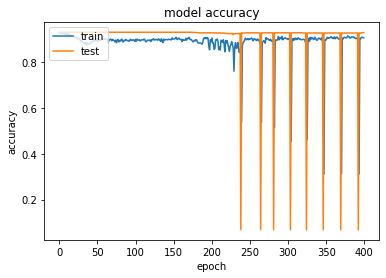

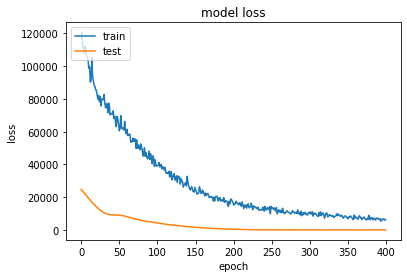

In [105]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_te = X_array_2[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

In [106]:
X_te.shape

(1510, 28)

In [107]:
A_te.shape

(1510, 1510)

In [ ]:
z = [X_te, A_te]
len(z)

2

In [ ]:
z[0].shape

(1000, 28)

In [ ]:
z[1].shape

(1000, 1000)

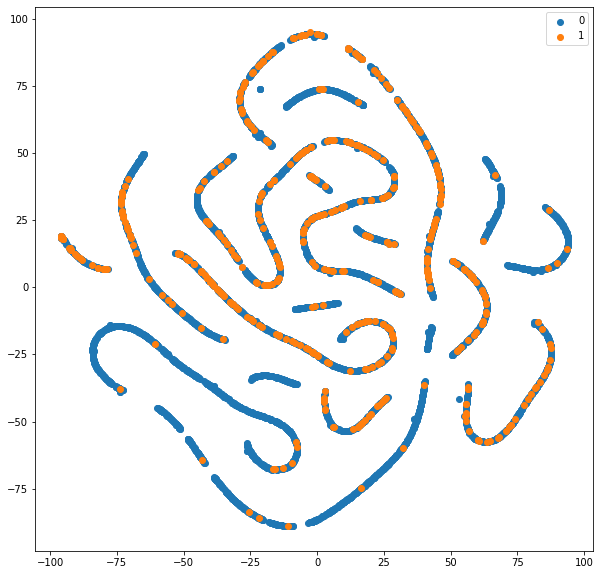

In [123]:
import sklearn.manifold

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X_array_2,A],batch_size=N)

#Get t-SNE Representation
x_tsne = sklearn.manifold.TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

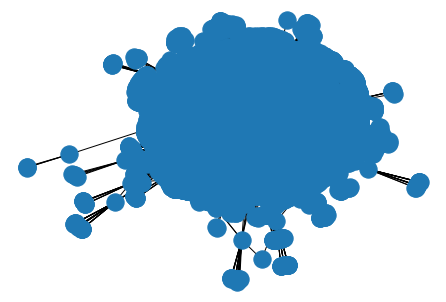

In [ ]:
import matplotlib.pyplot as plt
nx.draw(G)
plt.savefig("twitter_bot_dataset.png")